## Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [2]:
def load_variants_and_summaries(folder: os.PathLike) -> pd.DataFrame:
    dfs = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith('.evo'):
                filepath = os.path.join(root, filename)
                variant = os.path.dirname(filepath)[len(folder)+1:]
                df = pd.read_csv(filepath, sep='\t')
                df = df.set_index('generation_id')
                dfs.append((variant, df))
    return dict(dfs)

In [3]:
summary_per_variant = load_variants_and_summaries(folder='../evolution')

In [4]:
[(k, len(v)) for (k, v) in summary_per_variant.items()]

[('tests', 9)]

## Analysis

## Probability of Leap

### Genetic Material over Generations

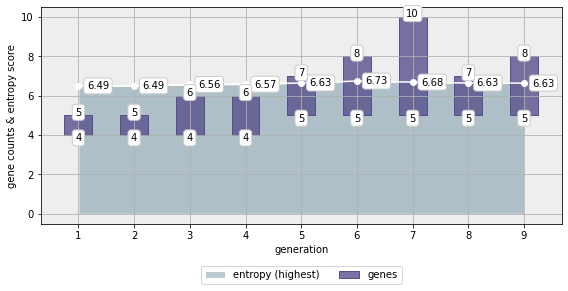

In [5]:
def plot_genetic_material_over_generations(df: pd.DataFrame, figlen: int = 8):
    
    def annotated_area(ax, ticks, values: pd.Series, color: str, label: str):
        values = [values[i] for i in ticks]
        ax.set_xticks(ticks)
        ax.fill_between(ticks, values, color=color, edgecolor='#fff', label=label)
        ax.plot(ticks, values, marker='o', color="#fff")
        for i, v in zip(ticks, values):
            ax.text(i + 0.35, v, str(round(v, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))

    def annotated_candles(ax, ticks, highs: pd.Series, lows: pd.Series, color: str, label: str):
        heights = [highs[i] - lows[i] for i in ticks]
        highs = [highs[i] for i in ticks]
        lows = [lows[i] for i in ticks]
        ax.set_xticks(ticks)
        ax.bar(ticks, height=heights, bottom=lows, width=(max(ticks)/len(ticks)) - 0.5, color=color + 'cc', edgecolor=color, label=label)
        for i, h, l in zip(ticks, highs, lows):
            ax.text(i, h + 0.15, str(round(h, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
            ax.text(i, l - 0.15, str(round(l, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))

    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    fig, ax = plt.subplots(figsize=(figlen, figlen/2))
    annotated_area(ax, ticks, df.dna_pool_entropy, color='#003f5c44', label='entropy (highest)')
    annotated_candles(ax, ticks, df.genes_max, df.genes_min, color='#58508d', label='genes')
    ax.set_facecolor("#eee")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('gene counts & entropy score')
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

plot_genetic_material_over_generations(df=summary_per_variant.get('tests'))

In [6]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.00/pmr=0.10/genes=05'))

AttributeError: 'NoneType' object has no attribute 'index'

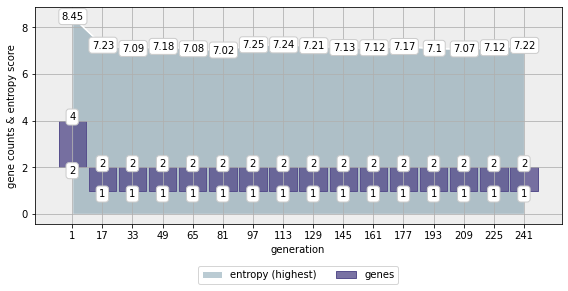

In [ ]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.00/pmr=0.10/genes=10'))

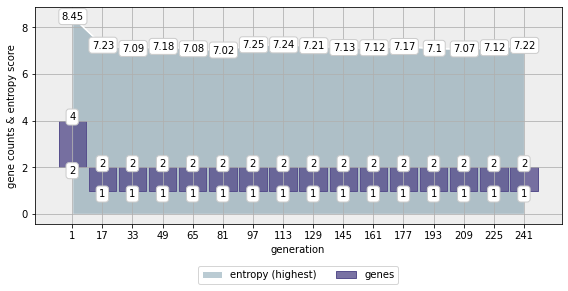

In [ ]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.00/pmr=0.10/genes=15'))

### Fitness over Generations

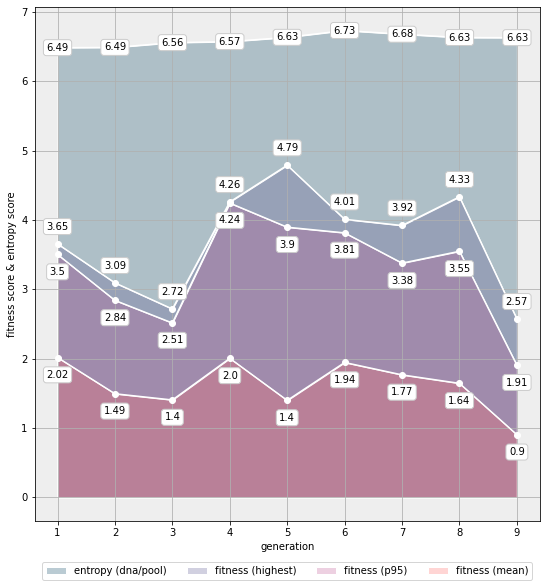

In [7]:
def plot_fitness_over_generations(df: pd.DataFrame, figlen: int = 8):
    def annotated_area(ax, ticks, values: pd.Series, color: str, label: str, ydist: float):
        values = [values[i] for i in ticks]
        ax.set_xticks(ticks)
        ax.fill_between(ticks, values, color=color, edgecolor='#fff', label=label)
        ax.plot(ticks, values, marker='o', color="#fff")
        for i, v in zip(ticks, values):
            ax.text(i, v + ydist, str(round(v, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    fig, ax = plt.subplots(figsize=(figlen, figlen))
    annotated_area(ax, ticks, df.dna_pool_entropy, color='#003f5c44', label='entropy (dna/pool)', ydist=0)
    annotated_area(ax, ticks, df.fitness_highest, color='#58508d44', label='fitness (highest)', ydist=0.25)
    annotated_area(ax, ticks, df.fitness_p95, color='#bc509044', label='fitness (p95)', ydist=-0.25)
    annotated_area(ax, ticks, df.fitness_mean, color='#ff636144', label='fitness (mean)', ydist=-0.25)
    ax.set_facecolor("#eee")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.125), ncol=4)
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('fitness score & entropy score')
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

plot_fitness_over_generations(df=summary_per_variant.get('tests'))

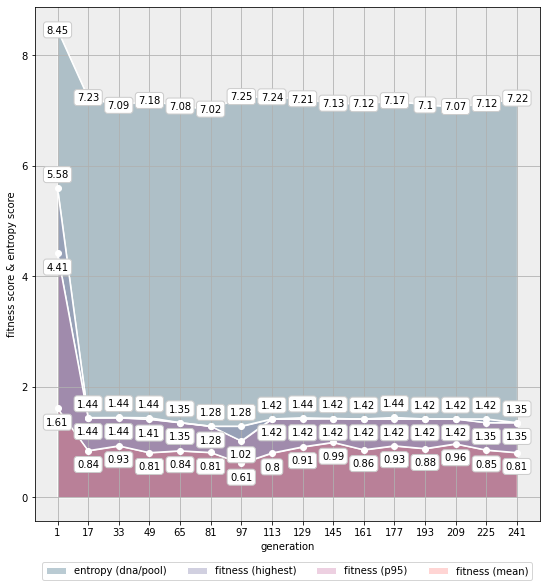

In [98]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.00/pmr=0.10/genes=05'))

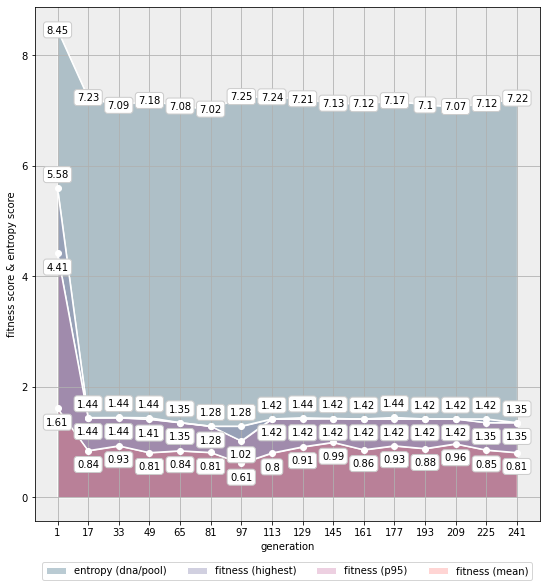

In [99]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.00/pmr=0.10/genes=10'))

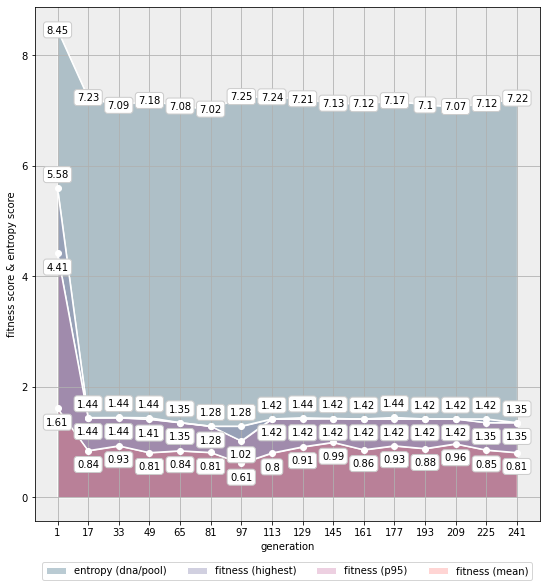

In [100]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.00/pmr=0.10/genes=15'))